# 1. Setting up the Pyspark Environment

In [1]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.
!pip install sparkxgb

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls

# Initialize findspark
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,172 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,223 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,613 kB]
Get:13 http://archive.ubuntu.com

# 2. Creating a Spark Session

In [2]:
# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

# 3. Mounitng Google Drive and Loading the Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = spark.read.csv("/content/drive/MyDrive/Air_Quality_Index_Prediction/all_pollutant_data_2017_2021.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- state_code: integer (nullable = true)
 |-- county_code: integer (nullable = true)
 |-- site_number: integer (nullable = true)
 |-- parameter_code: integer (nullable = true)
 |-- poc: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- datum: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- sample_duration_code: string (nullable = true)
 |-- sample_duration: string (nullable = true)
 |-- pollutant_standard: string (nullable = true)
 |-- date_local: string (nullable = true)
 |-- units_of_measure: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- observation_count: integer (nullable = true)
 |-- observation_percent: double (nullable = true)
 |-- validity_indicator: string (nullable = true)
 |-- arithmetic_mean: double (nullable = true)
 |-- first_max_value: double (nullable = true)
 |-- first_max_hour: integer (nullable = true)
 |-- aqi: double (nullable = true)
 |-- method_co

In [5]:
df.show(5)

+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+--------------------+--------------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+--------------------+---------------+-----------------+--------+------+-----+---------+--------------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc| latitude| longitude|datum|      parameter|sample_duration_code|     sample_duration|pollutant_standard|date_local| units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|              method|local_site_name|     site_address|   state|county| city|cbsa_code|                cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+----

In [6]:
df.describe().show()

+-------+----------+------------------+------------------+------------------+------------------+------------------+-------------------+------+--------------+--------------------+--------------------+------------------+----------+--------------------+--------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------+------+-----------------+-----------------+--------------------+-------------------+
|summary|state_code|       county_code|       site_number|    parameter_code|               poc|          latitude|          longitude| datum|     parameter|sample_duration_code|     sample_duration|pollutant_standard|date_local|    units_of_measure|          event_type| observation_count|observation_percent|validity_indicator|  arithmetic_mean|   first_max_value|    first_max_hour|               aqi|       method_co

# Feature Engineering

# 4. Getting the Null Values of each Coloumn

In [7]:
from pyspark.sql import functions as F

# Count null values in each column
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

# Show the result
null_counts.show()

+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+------+-----------+------+---------------+------------+-----+------+----+---------+------+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude|longitude|datum|parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|   aqi|method_code|method|local_site_name|site_address|state|county|city|cbsa_code|  cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+---------------

## 5. Exploring each column

In [8]:
df.select('event_type').distinct().show()

+--------------------+
|          event_type|
+--------------------+
|     Events Included|
|           No Events|
|Concurred Events ...|
|     Events Excluded|
+--------------------+



In [9]:
df.select('datum').distinct().show()

+-----+
|datum|
+-----+
|NAD83|
|WGS84|
+-----+



In [10]:
df.select('cbsa').distinct().show(truncate=False)

+--------------------------+
|cbsa                      |
+--------------------------+
|Durango, CO               |
|null                      |
|Grand Junction, CO        |
|Glenwood Springs, CO      |
|Greeley, CO               |
|Montrose, CO              |
|Pueblo, CO                |
|Steamboat Springs, CO     |
|Craig, CO                 |
|Boulder, CO               |
|Ca¤on City, CO            |
|Denver-Aurora-Lakewood, CO|
|Colorado Springs, CO      |
|Fort Collins, CO          |
+--------------------------+



In [11]:
df.select('cbsa_code').distinct().show(truncate=False)

+---------+
|cbsa_code|
+---------+
|44460    |
|24540    |
|null     |
|14500    |
|19740    |
|18780    |
|24060    |
|24300    |
|20420    |
|33940    |
|22660    |
|17820    |
|39380    |
|15860    |
+---------+



In [12]:
df.select('first_max_value').distinct().count()

2972

In [13]:
df.select('pollutant_standard').distinct().show(truncate=False, n=1000)

+------------------+
|pollutant_standard|
+------------------+
|null              |
|NO2 Annual 1971   |
|PM25 24-hour 2012 |
|Ozone 8-Hour 1997 |
|SO2 1-hour 2010   |
|CO 1-hour 1971    |
|Ozone 1-hour 1979 |
|PM10 24-hour 2006 |
|PM25 24-hour 1997 |
|PM25 Annual 2012  |
|SO2 3-hour 1971   |
|SO2 24-hour 1971  |
|PM25 24-hour 2006 |
|NO2 1-hour 2010   |
|PM25 24-hour 2024 |
|PM25 Annual 1997  |
|Ozone 8-Hour 2008 |
|SO2 Annual 1971   |
|CO 8-hour 1971    |
|PM25 Annual 2006  |
|PM25 Annual 2024  |
|Ozone 8-hour 2015 |
+------------------+



## 6. Information about pollutants

7 Pollutants in total. Each codes corresponds to a pollutant -

1. Nitrogen dioxide (NO2) - 42602
2. Carbon monoxide (CO) - 42101
3. PM10 Total 0-10um STP - 81102
4. PM2.5 - Local Conditions - 88101
5. Benzene (C6H6) - 45201
6. Ozone (O3) - 44201
7. Sulfur dioxide (SO2) - 42401

In [14]:
from pyspark.sql.functions import when

df_pollutant_codes = df.select('parameter_code').distinct()
df_pollutant_codes = df_pollutant_codes.withColumnRenamed('parameter_code', 'pollutant_code')

df_pollutant_codes = df_pollutant_codes.withColumn(
    'pollutant_name',
    when(df_pollutant_codes.pollutant_code == 42602, 'Nitrogen dioxide (NO2)')
    .when(df_pollutant_codes.pollutant_code == 42101, 'Carbon monoxide (CO)')
    .when(df_pollutant_codes.pollutant_code == 81102, 'PM10 Total 0-10um STP')
    .when(df_pollutant_codes.pollutant_code == 88101, 'PM2.5 - Local Conditions')
    .when(df_pollutant_codes.pollutant_code == 45201, 'Benzene (C6H6)')
    .when(df_pollutant_codes.pollutant_code == 44201, 'Ozone (O3)')
    .when(df_pollutant_codes.pollutant_code == 42401, 'Sulfur dioxide (SO2)')
    .otherwise('Unknown')
)

df_pollutant_codes.show()

+--------------+--------------------+
|pollutant_code|      pollutant_name|
+--------------+--------------------+
|         42602|Nitrogen dioxide ...|
|         42101|Carbon monoxide (CO)|
|         81102|PM10 Total 0-10um...|
|         88101|PM2.5 - Local Con...|
|         45201|      Benzene (C6H6)|
|         44201|          Ozone (O3)|
|         42401|Sulfur dioxide (SO2)|
+--------------+--------------------+



## 7. Filling in Null values in pollutant_standard for parameter benzene (Null Value Count: 50723)

In [15]:
df.filter(df['pollutant_standard'].isNull()).show()

+----------+-----------+-----------+--------------+---+--------+----------+-----+--------------------+--------------------+---------------+------------------+----------+--------------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+--------------------+---------------+---------------+--------+------+------+---------+--------------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude| longitude|datum|           parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|    units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|              method|local_site_name|   site_address|   state|county|  city|cbsa_code|                cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+----------+-----+-------------------

In [16]:
from pyspark.sql.functions import col, sum

# Group by 'parameter', , 'parameter_code', 'sample_duration' and count null values in 'pollutant_standard'
df.groupBy("parameter", "parameter_code", "sample_duration") \
  .agg(sum(col("pollutant_standard").isNull().cast("int")).alias("null_count")) \
  .show(truncate=False)


+------------------------+--------------+-----------------------+----------+
|parameter               |parameter_code|sample_duration        |null_count|
+------------------------+--------------+-----------------------+----------+
|PM10 Total 0-10um STP   |81102         |1 HOUR                 |8257      |
|PM2.5 - Local Conditions|88101         |1 HOUR                 |40406     |
|Sulfur dioxide          |42401         |24-HR BLK AVG          |0         |
|Benzene                 |45201         |3 HOURS                |776       |
|Carbon monoxide         |42101         |1 HOUR                 |0         |
|Ozone                   |44201         |8-HR RUN AVG BEGIN HOUR|0         |
|PM10 Total 0-10um STP   |81102         |24 HOUR                |0         |
|Ozone                   |44201         |1 HOUR                 |0         |
|Carbon monoxide         |42101         |8-HR RUN AVG END HOUR  |0         |
|PM2.5 - Local Conditions|88101         |24 HOUR                |0         |

Pollutant Standards for all pollutants: https://aqs.epa.gov/aqsweb/documents/codetables/pollutant_standards.html

1. Benzene - No Pollutant Standard Available

2. PM10 Total 0-10um STP - No Pollutant Standard Available

3. PM2.5 - Local Conditions - No Pollutant Standard Available

The designation of **"no pollutant standard available"** arises from the **lack of sample duration** for these pollutants, specifically lacking entries like "1 HOUR" for these pollutants with null values. Typically, ***pollutant standards are established for pollutants based on 24-HOUR and 8-HOUR RUN AVERAGE BEGIN HOUR intervals.***

In [17]:
# Checking if values gets filled for all 3 parameter
df.na.fill("No Standard Available", "pollutant_standard").show()

+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+--------------------+--------------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+--------------------+---------------+-----------------+--------+------+-----+---------+--------------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc| latitude| longitude|datum|      parameter|sample_duration_code|     sample_duration|pollutant_standard|date_local| units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|              method|local_site_name|     site_address|   state|county| city|cbsa_code|                cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+----

In [18]:
df = df.na.fill("No Standard Available", "pollutant_standard")

In [19]:
# Checking if values got filled for all 3 parameter

df.groupBy("parameter", "parameter_code", "sample_duration") \
  .agg(sum(col("pollutant_standard").isNull().cast("int")).alias("null_count")) \
  .show(truncate=False)

+------------------------+--------------+-----------------------+----------+
|parameter               |parameter_code|sample_duration        |null_count|
+------------------------+--------------+-----------------------+----------+
|PM10 Total 0-10um STP   |81102         |1 HOUR                 |0         |
|PM2.5 - Local Conditions|88101         |1 HOUR                 |0         |
|Sulfur dioxide          |42401         |24-HR BLK AVG          |0         |
|Benzene                 |45201         |3 HOURS                |0         |
|Carbon monoxide         |42101         |1 HOUR                 |0         |
|Ozone                   |44201         |8-HR RUN AVG BEGIN HOUR|0         |
|PM10 Total 0-10um STP   |81102         |24 HOUR                |0         |
|Ozone                   |44201         |1 HOUR                 |0         |
|Carbon monoxide         |42101         |8-HR RUN AVG END HOUR  |0         |
|PM2.5 - Local Conditions|88101         |24 HOUR                |0         |

## 8. Filling in Null values for cbsa and cbsa_code (Null Value Count: 116474 and 116474)

The **Core-Based Statistical Area (CBSA)** is a geographic region defined by the Office of Management and Budget (OMB) that includes a central urban area and its surrounding communities. ***For sites not situated within a metropolitan area, we assign a random code of "99999" to indicate this status. Consequently, the null values in the CBSA field are replaced with "Non-CBSA Area."***

In [20]:
# Fill null values in cbsa and cbsa_code
df = df.withColumn("cbsa_code",
                           F.when(df["cbsa_code"].isNull(), 99999).otherwise(df["cbsa_code"])) \
               .withColumn("cbsa",
                           F.when(df["cbsa"].isNull(), "Non-CBSA Area").otherwise(df["cbsa"]))

# Show results
df.show(truncate=False)

+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+--------------------+---------------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+-------------------------------------------------------------+---------------+-----------------+--------+------+-----+---------+--------------------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude |longitude |datum|parameter      |sample_duration_code|sample_duration      |pollutant_standard|date_local|units_of_measure |event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|aqi |method_code|method                                                       |local_site_name|site_address     |state   |county|city |cbsa_code|cbsa                      |date_of_last_change|
+-----

Checking for remaining null valued columns

In [21]:
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

null_counts.show()

+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+------+-----------+------+---------------+------------+-----+------+----+---------+----+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude|longitude|datum|parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|   aqi|method_code|method|local_site_name|site_address|state|county|city|cbsa_code|cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-

## 9. Filling in Null values for local_site_name (Null Value Count: 33148)

In [22]:
from pyspark.sql.functions import col, sum

df.groupBy("state_code", "county_code", "site_number", "site_address", "latitude", "longitude") \
  .agg(sum(col("local_site_name").isNull().cast("int")).alias("null_count")) \
  .show(truncate=False, n=1000)


+----------+-----------+-----------+-------------------------------------------------+---------+-----------+----------+
|state_code|county_code|site_number|site_address                                     |latitude |longitude  |null_count|
+----------+-----------+-----------+-------------------------------------------------+---------+-----------+----------+
|8         |45         |14         |Flattops #3                                      |39.799   |-107.617   |0         |
|8         |69         |7          |ROCKY MOUNTAIN NP                                |40.27813 |-105.54564 |0         |
|8         |31         |27         |971 Yuma Street                                  |39.73217 |-105.0153  |0         |
|8         |3          |3          |425 4TH ST.                                      |37.469584|-105.863175|0         |
|8         |13         |3          |350 KIMBARK ST.                                  |40.164576|-105.100856|0         |
|8         |77         |17         |650 

**Every "local_site_name" has it's unique "site_address".** We can use this to fill the null values. Once we come up with a "local_site_name" for these null values, we need to store the ***{ "site_address" : "local_site_name" }*** as a dictionary so that we can use it in future to fill the null values in the unseen data (or test data). Below are the "site_address" which has null values in "local_site_name" -

1. Meeker, Colorado Plant Science Building :
Upper Colorado Environmental Plant Center

2. Piceance Basin - Mobile : Piceance Basin

3. 512 OWENS DR. : Westminster

4. Weminuche Wilderness Area - Shamrock Station : USDA-Forest Service Shamrock Monitoring Site

5. 398 CO- 151 Pagosa Springs, CO : Lake Capote Recreation Area

In [23]:
site_mapping = {
    "Meeker, Colorado Plant Science Building": "Upper Colorado Environmental Plant Center",
    "Piceance Basin - Mobile": "Piceance Basin",
    "512 OWENS DR.": "Westminster",
    "Weminuche Wilderness Area - Shamrock Station": "USDA-Forest Service Shamrock Monitoring Site",
    "398 CO- 151 Pagosa Springs, CO": "Lake Capote Recreation Area"
}

In [24]:
from pyspark.sql.functions import when, col

for site_address, local_site_name in site_mapping.items():
    df = df.withColumn(
    "local_site_name",
    when(col("site_address") == site_address,
         when(col("local_site_name").isNull(), local_site_name).otherwise(col("local_site_name")))
    .otherwise(col("local_site_name"))
)

In [25]:
df.select('local_site_name').distinct().show(truncate=False, n=1000)

+--------------------------------------------+
|local_site_name                             |
+--------------------------------------------+
|Silt-Collbran                               |
|Flattops #3                                 |
|McClure Pass                                |
|Greeley - Weld County Tower                 |
|DELTA HEALTH DEPT                           |
|Platteville - Middle School                 |
|Pawnee Buttes                               |
|I-25                                        |
|Grand Mesa                                  |
|MT CRESTED BUTTE REALTY BLDG                |
|Welby                                       |
|GRAND JUNCTION - POWELL BLDG                |
|Norwood                                     |
|Platteville Atmospheric Observatory         |
|Ripple Creek Pass                           |
|MANITOU SPRINGS                             |
|La Casa                                     |
|Paradox                                     |
|USDA-Forest 

In [26]:
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

null_counts.show()

+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+------+-----------+------+---------------+------------+-----+------+----+---------+----+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude|longitude|datum|parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|   aqi|method_code|method|local_site_name|site_address|state|county|city|cbsa_code|cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-

## 10. Filling Null Values in method_code (Null Value Count: 6)

In [27]:
from pyspark.sql.functions import col, sum

df.groupBy("method") \
  .agg(sum(col("method_code").isNull().cast("int")).alias("null_count")) \
  .show(truncate=False, n=1000)


+---------------------------------------------------------------------------------------------------------------------+----------+
|method                                                                                                               |null_count|
+---------------------------------------------------------------------------------------------------------------------+----------+
|Teledyne Model 602 Beta plus w/VSCC - Beta Attenuation                                                               |0         |
|R - P Co Partisol Model 2025 - Gravimetric                                                                           |0         |
|Teledyne T640 at 5.0 LPM (Corrected) - Broadband spectroscopy                                                        |0         |
|Instrumental - Ultra Violet 2B Model 202                                                                             |0         |
|R & P Model 2000 PM-2.5 Air Sampler w/VSCC - Gravimetric                          

In [28]:
df.filter(df["method"] == " - ").show()

+----------+-----------+-----------+--------------+---+---------+-----------+-----+---------+--------------------+--------------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+------+--------------------+--------------------+--------+---------+-------------+---------+-------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc| latitude|  longitude|datum|parameter|sample_duration_code|     sample_duration|pollutant_standard|date_local| units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|method|     local_site_name|        site_address|   state|   county|         city|cbsa_code|         cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+---------+-----------+-----+---------+--------------------+--

Since, there is no method for these 6 rows, we can replace the null values with a ***new method code "99999"*** which ***indicates no method mentioned or " - "***.

In [29]:
from pyspark.sql import functions as F

df = df.withColumn(
    "method_code",
    F.when(F.col("method_code").isNull(), "99999").otherwise(F.col("method_code"))
)

In [30]:
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+------+-----------+------+---------------+------------+-----+------+----+---------+----+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude|longitude|datum|parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|   aqi|method_code|method|local_site_name|site_address|state|county|city|cbsa_code|cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-

## 11. Filling Null Values in aqi (Null Value Count: 157248)

The reason for dropping rows with null values in the `aqi` column is that these rows indicate an insufficient duration of recordings to calculate an accurate Air Quality Index (AQI). Since AQI is a critical metric for assessing air quality, its absence implies that essential data is missing. Including these incomplete records would introduce inaccuracies and reduce the reliability of any subsequent analysis or modeling, so it is more effective to drop them to maintain data integrity.

In [31]:
df = df.filter(df["aqi"].isNotNull())

In [32]:
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

null_counts.show()

+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+---+-----------+------+---------------+------------+-----+------+----+---------+----+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude|longitude|datum|parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|aqi|method_code|method|local_site_name|site_address|state|county|city|cbsa_code|cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------

Now let's convert the continous variable to a categorical variable using the AQI table - (Can be found here: https://www.epa.gov/outdoor-air-quality-data/air-data-basic-information)

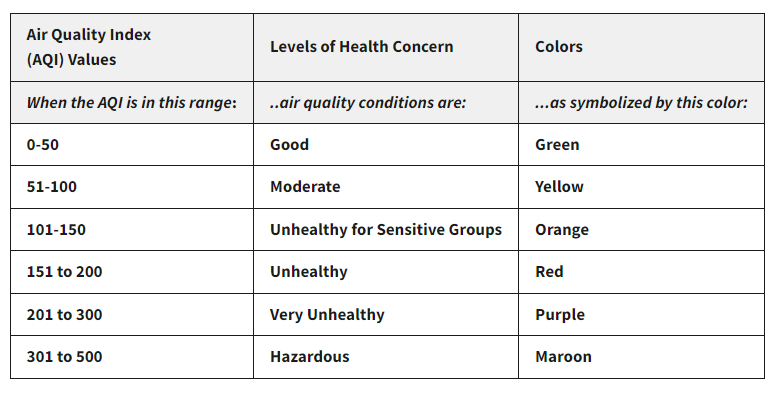

In [33]:
df = df.withColumn(
    "aqi_category",
    F.when((F.col("aqi") >= 0) & (F.col("aqi") <= 50), "Good")
    .when((F.col("aqi") >= 51) & (F.col("aqi") <= 100), "Moderate")
    .when((F.col("aqi") >= 101) & (F.col("aqi") <= 150), "Unhealthy for Sensitive Groups")
    .when((F.col("aqi") >= 151) & (F.col("aqi") <= 200), "Unhealthy")
    .when((F.col("aqi") >= 201) & (F.col("aqi") <= 300), "Very Unhealthy")
    .when((F.col("aqi") >= 301) & (F.col("aqi") <= 500), "Hazardous")
    .otherwise("Unknown")  # Handling any AQI values outside the expected range
)

In [34]:
df.show(truncate=False)

+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+--------------------+---------------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+-------------------------------------------------------------+---------------+-----------------+--------+------+-----+---------+--------------------------+-------------------+------------+
|state_code|county_code|site_number|parameter_code|poc|latitude |longitude |datum|parameter      |sample_duration_code|sample_duration      |pollutant_standard|date_local|units_of_measure |event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|aqi |method_code|method                                                       |local_site_name|site_address     |state   |county|city |cbsa_code|cbsa                      |date_of_last_c

In [35]:
from pyspark.ml.feature import StringIndexer

# Defining the StringIndexer for label encoding
indexer = StringIndexer(inputCol="aqi_category", outputCol="aqi_category_index")

# Fitting the StringIndexer to the data to get the labels
indexer = indexer.fit(df)  # Fit the indexer before transforming

df = indexer.transform(df) # Transform the dataframe
df.show()

category_mapping = indexer.labels # Access the labels after fitting

for idx, label in enumerate(category_mapping):
    print(f"Class {label} is mapped to {idx}")

+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+--------------------+--------------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+--------------------+---------------+-----------------+--------+------+-----+---------+--------------------+-------------------+------------+------------------+
|state_code|county_code|site_number|parameter_code|poc| latitude| longitude|datum|      parameter|sample_duration_code|     sample_duration|pollutant_standard|date_local| units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|              method|local_site_name|     site_address|   state|county| city|cbsa_code|                cbsa|date_of_last_change|aqi_category|aqi_category_index|
+----------+-----------+-----------+--

In [36]:
df.select('aqi_category_index').distinct().show(truncate=False)

+------------------+
|aqi_category_index|
+------------------+
|0.0               |
|1.0               |
|4.0               |
|3.0               |
|2.0               |
|5.0               |
+------------------+



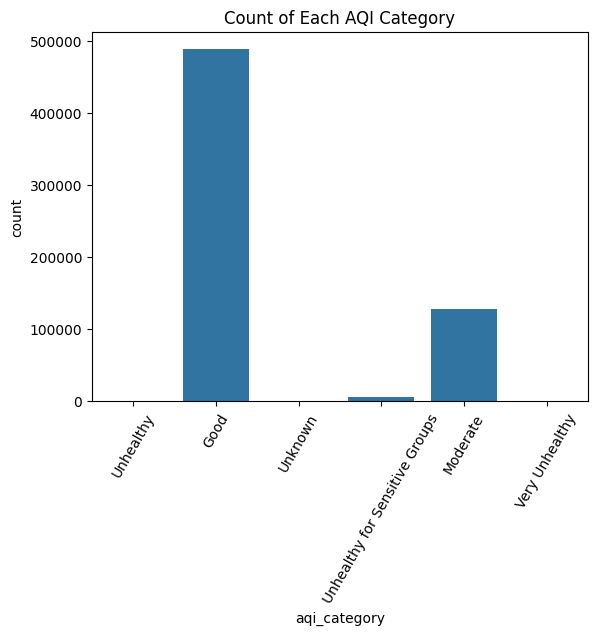

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

category_counts = df.groupBy('aqi_category').count().toPandas()
sns.barplot(data=category_counts, x='aqi_category', y='count')
plt.title('Count of Each AQI Category')
plt.xticks(rotation=60)
plt.show()

As you can see, the dataset is highly imbalanced. Let's balance it using upsampling or undersampling.

In [38]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

# Define the target number of rows for each class (100k)
target_class_count = 100000

# Group by the target column to calculate the current number of records in each class
class_counts = df.groupBy('aqi_category_index').count()

# Function to perform upsampling or downsampling based on the target class count
def balance_class(df: DataFrame, target_class_count: int):
    # Separate classes based on the new target variable mappings
    df_good = df.filter(df.aqi_category_index == 0)  # Good class is now mapped to 0
    df_moderate = df.filter(df.aqi_category_index == 1)  # Moderate class is now mapped to 1
    df_unknown = df.filter(df.aqi_category_index == 5)  # Unknown class is now mapped to 5
    df_unhealthy = df.filter(df.aqi_category_index == 3)  # Unhealthy class is now mapped to 3
    df_unhealthy_sensitive = df.filter(df.aqi_category_index == 2)  # Unhealthy for Sensitive Groups is mapped to 2
    df_very_unhealthy = df.filter(df.aqi_category_index == 4)  # Very Unhealthy class is now mapped to 4

    # Down-sample "Good" class to 100k
    df_good = df_good.sample(False, target_class_count / df_good.count())

    # Upsample other classes to 100k (if they have fewer rows)
    df_unknown = df_unknown.sample(True, target_class_count / df_unknown.count())
    df_unhealthy = df_unhealthy.sample(True, target_class_count / df_unhealthy.count())
    df_unhealthy_sensitive = df_unhealthy_sensitive.sample(True, target_class_count / df_unhealthy_sensitive.count())
    df_very_unhealthy = df_very_unhealthy.sample(True, target_class_count / df_very_unhealthy.count())

    # Ensure "Moderate" class is kept at 100k
    df_moderate = df_moderate.limit(target_class_count)

    # Combine all balanced classes into one DataFrame
    balanced_df = df_good.union(df_moderate).union(df_unknown).union(df_unhealthy).union(df_unhealthy_sensitive).union(df_very_unhealthy)

    return balanced_df

# Balance the dataframe
df = balance_class(df, target_class_count)

# Show the class distribution in the final dataset
df.groupBy('aqi_category_index').count().show()

+------------------+------+
|aqi_category_index| count|
+------------------+------+
|               0.0|100002|
|               1.0|100000|
|               4.0| 99702|
|               3.0| 99860|
|               2.0|100279|
|               5.0| 99781|
+------------------+------+



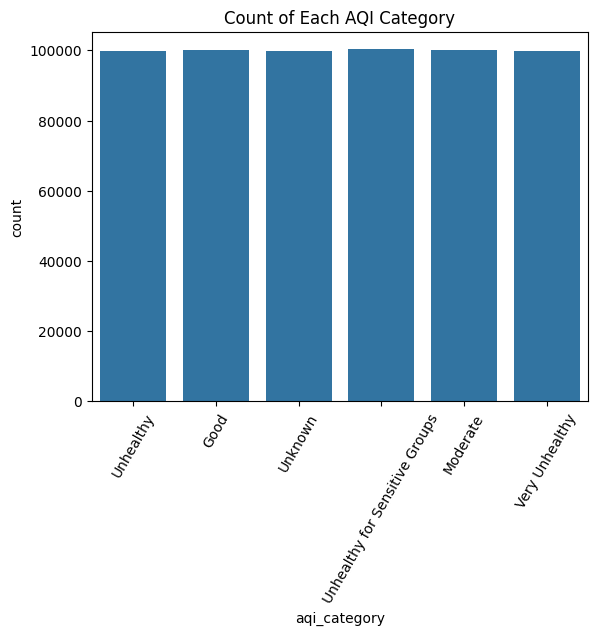

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

category_counts = df.groupBy('aqi_category').count().toPandas()
sns.barplot(data=category_counts, x='aqi_category', y='count')
plt.title('Count of Each AQI Category')
plt.xticks(rotation=60)
plt.show()

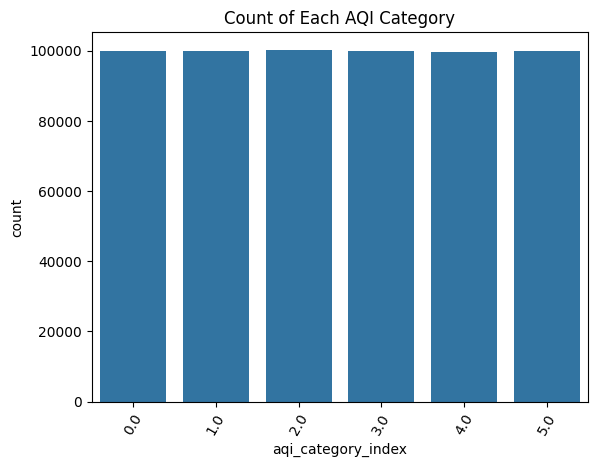

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

category_counts = df.groupBy('aqi_category_index').count().toPandas()
sns.barplot(data=category_counts, x='aqi_category_index', y='count')
plt.title('Count of Each AQI Category')
plt.xticks(rotation=60)
plt.show()

### Now all null values are filled, continous target variable is converted to categorical variable and the dataset is balanced. we can start exploring the data now

# Data Exploration

In [41]:
from pyspark.sql.functions import col, count, mean, max, min, dayofmonth, hour
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Distribution of Carbon Monoxide Levels

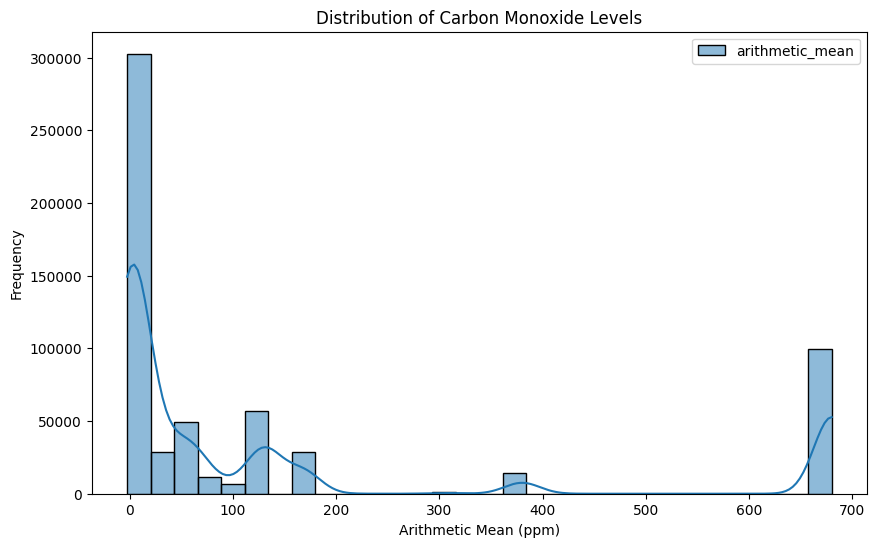

In [42]:
co_distribution = df.select("arithmetic_mean").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(co_distribution, bins=30, kde=True)
plt.title("Distribution of Carbon Monoxide Levels")
plt.xlabel("Arithmetic Mean (ppm)")
plt.ylabel("Frequency")
plt.show()


This plot shows the distribution of carbon monoxide (CO) levels (ppm), with most values concentrated near zero. The histogram is overlaid with a KDE curve, highlighting a right-skewed pattern due to occasional high CO levels. This suggests that extreme values are rare compared to low CO levels.

## 2. Average Carbon Monoxide Levels by County

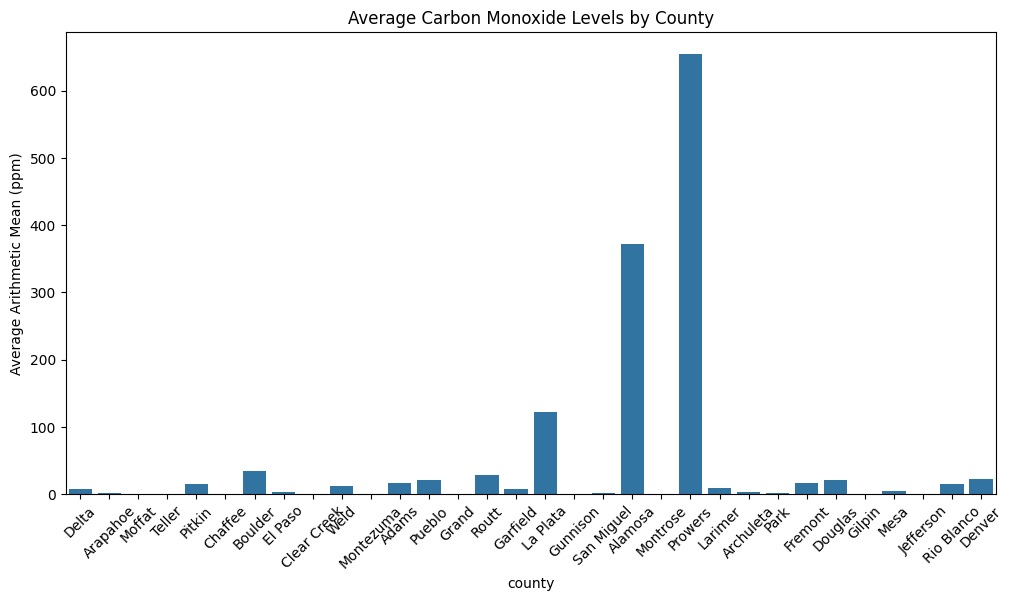

In [43]:
avg_co_by_county = df.groupBy("county").agg({"arithmetic_mean": "avg"}).toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_co_by_county, x="county", y="avg(arithmetic_mean)")
plt.title("Average Carbon Monoxide Levels by County")
plt.xticks(rotation=45)
plt.ylabel("Average Arithmetic Mean (ppm)")
plt.show()


​This bar chart shows the average carbon monoxide (CO) levels across various counties. The x-axis represents the counties, while the y-axis indicates the average CO levels. Counties such as Prowers and Montrose exhibit higher levels compared to others like Gunnison or Gilpin.

## 3. Time Series of Carbon Monoxide Levels

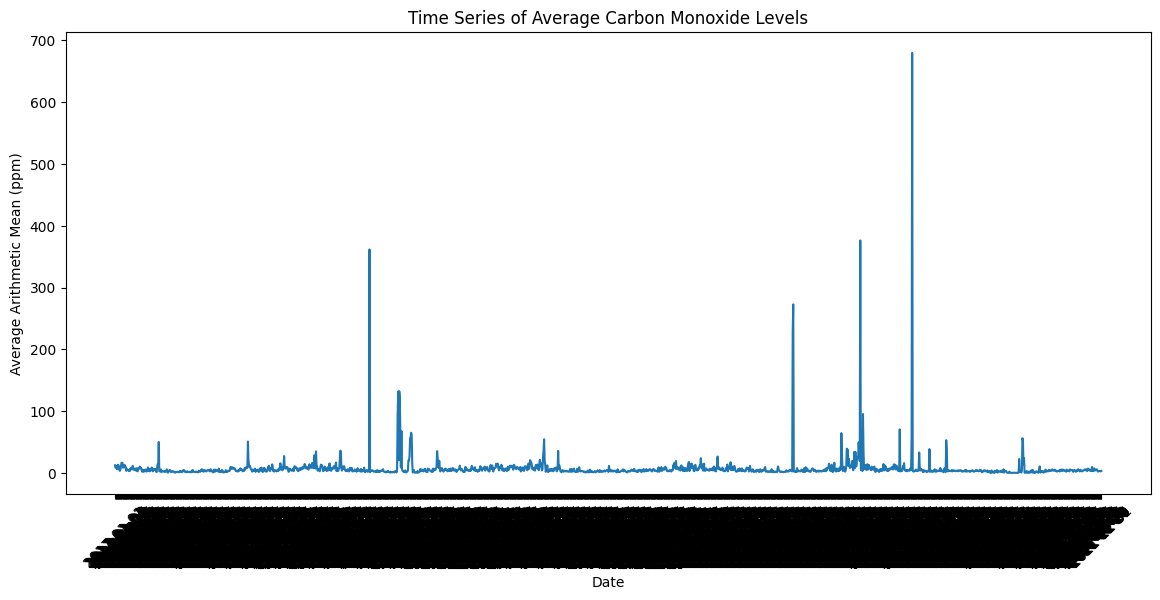

In [44]:
time_series_co = df.groupBy("date_local").agg({"arithmetic_mean": "avg"}).orderBy("date_local").toPandas()
plt.figure(figsize=(14, 6))
plt.plot(time_series_co['date_local'], time_series_co['avg(arithmetic_mean)'])
plt.title("Time Series of Average Carbon Monoxide Levels")
plt.xlabel("Date")
plt.ylabel("Average Arithmetic Mean (ppm)")
plt.xticks(rotation=45)
plt.show()

This line graph represents the time series of average carbon monoxide (CO) levels over a period. The x-axis shows the dates, while the y-axis indicates CO levels. It highlights periodic spikes, suggesting fluctuations in CO levels over time.

## 4. Maximum Carbon Monoxide Levels by Date

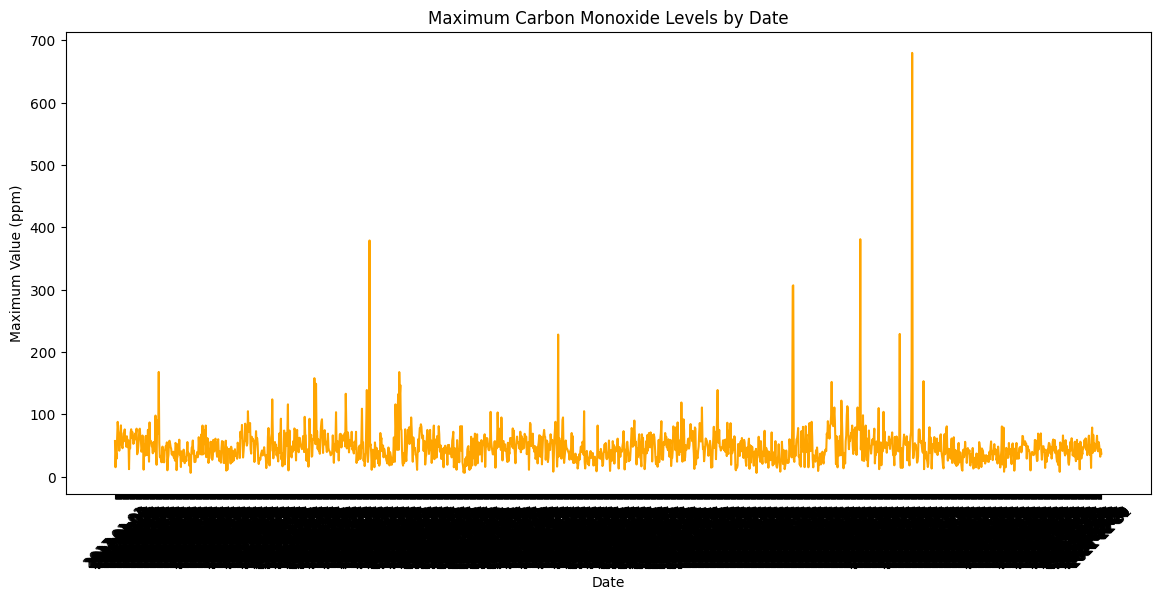

In [45]:
max_co_by_date = df.groupBy("date_local").agg({"first_max_value": "max"}).orderBy("date_local").toPandas()
plt.figure(figsize=(14, 6))
plt.plot(max_co_by_date['date_local'], max_co_by_date['max(first_max_value)'], color='orange')
plt.title("Maximum Carbon Monoxide Levels by Date")
plt.xlabel("Date")
plt.ylabel("Maximum Value (ppm)")
plt.xticks(rotation=45)
plt.show()


​This visualization shows the maximum carbon monoxide levels over time. The x-axis represents dates, and the y-axis represents carbon monoxide levels, with peaks indicating higher concentrations. The data suggests significant variability, with occasional sharp spikes in maximum levels.

## 5. Average Carbon Monoxide Levels by Pollutant Standard

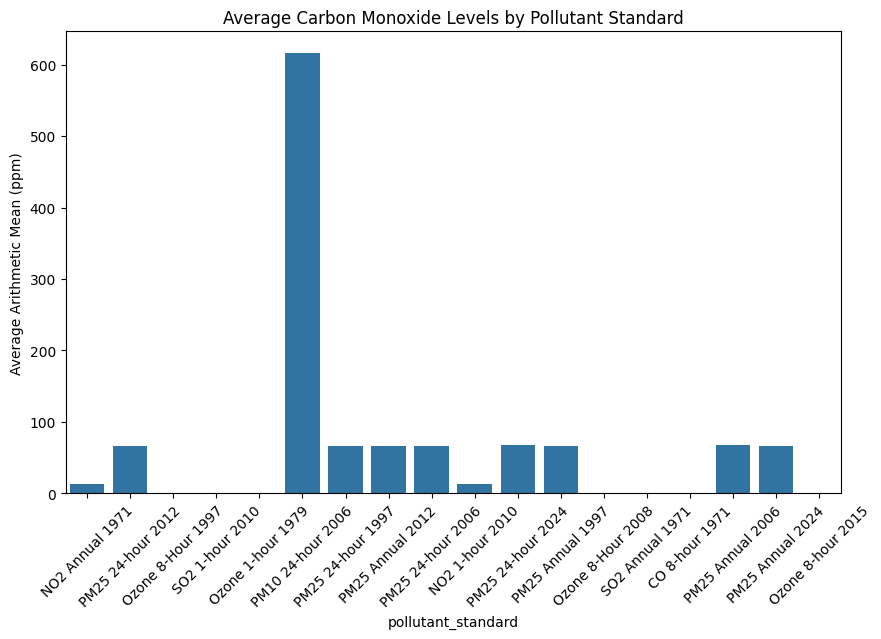

In [46]:
avg_co_by_standard = df.groupBy("pollutant_standard").agg({"arithmetic_mean": "avg"}).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_co_by_standard, x="pollutant_standard", y="avg(arithmetic_mean)")
plt.title("Average Carbon Monoxide Levels by Pollutant Standard")
plt.ylabel("Average Arithmetic Mean (ppm)")
plt.xticks(rotation=45)
plt.show()


​This bar chart shows the average carbon monoxide levels by different pollutant standards. Each bar represents the average CO level for a specific standard, with the x-axis showing various pollutant standards and the y-axis showing average carbon monoxide levels. The chart highlights a particularly high level in the pollutant standard "PM10 24-hour 1979."

# 6. Count Plot of Air Quality Parameters

<ipython-input-47-05a86c3fe28b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df.toPandas(), x='parameter', order=parameter_counts.index, palette='viridis')


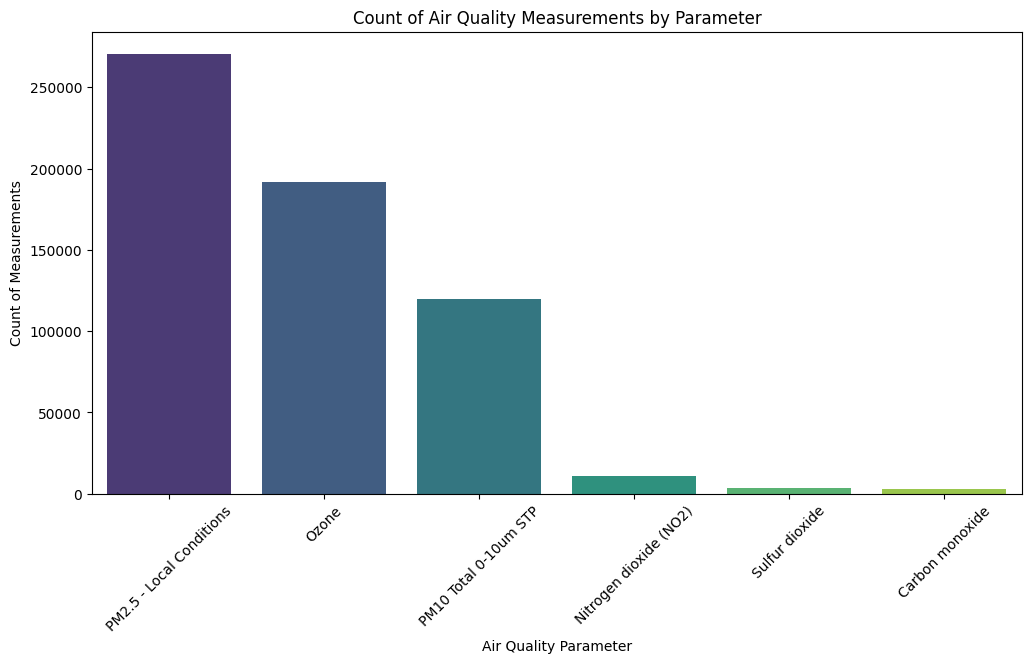

In [47]:
plt.figure(figsize=(12, 6))
# Convert the 'parameter' column to a Pandas Series and then apply value_counts()
parameter_counts = df.select('parameter').toPandas()['parameter'].value_counts()
sns.countplot(data=df.toPandas(), x='parameter', order=parameter_counts.index, palette='viridis')
plt.title("Count of Air Quality Measurements by Parameter")
plt.xlabel("Air Quality Parameter")
plt.ylabel("Count of Measurements")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


​This bar chart depicts the count of air quality measurements for various parameters. The x-axis lists the air quality parameters, and the y-axis represents the count of measurements. "PM2.5 - Local Conditions" and "Ozone" have significantly higher measurement counts compared to other parameters like "Carbon monoxide" and "Nitrogen dioxide (NO2)."

## 7. Boxplot of Carbon Monoxide Levels by Event Type

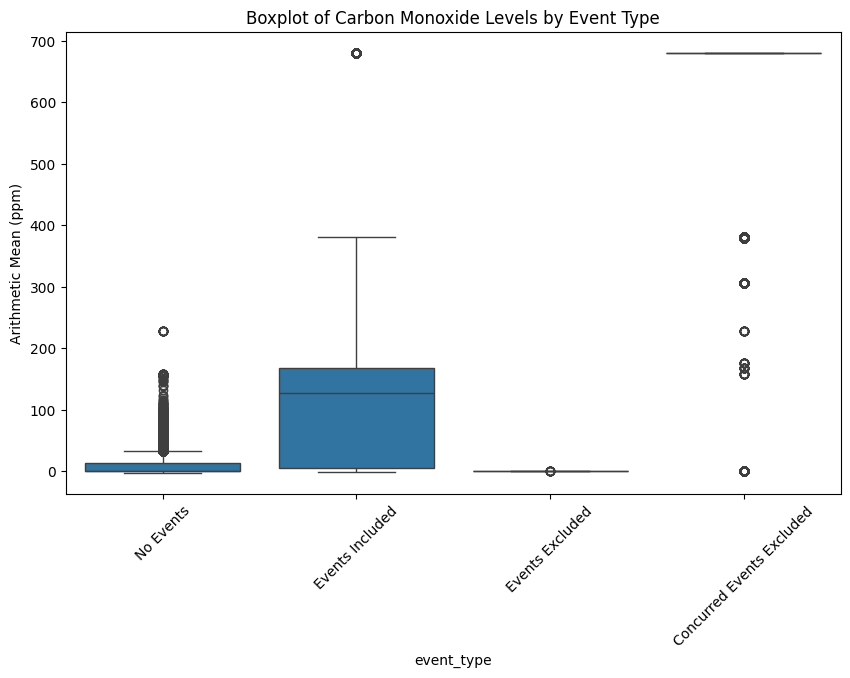

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.toPandas(), x="event_type", y="arithmetic_mean")
plt.title("Boxplot of Carbon Monoxide Levels by Event Type")
plt.ylabel("Arithmetic Mean (ppm)")
plt.xticks(rotation=45)
plt.show()

The boxplot illustrates the distribution of carbon monoxide levels across different event types. It reveals that the “No Events” category generally has the lowest CO levels, while “Concurred Events Excluded” has the highest. Outliers are present in all categories, indicating some unusually high CO readings.

## 8. Scatter Plot of First Max Value vs. Arithmetic Mean

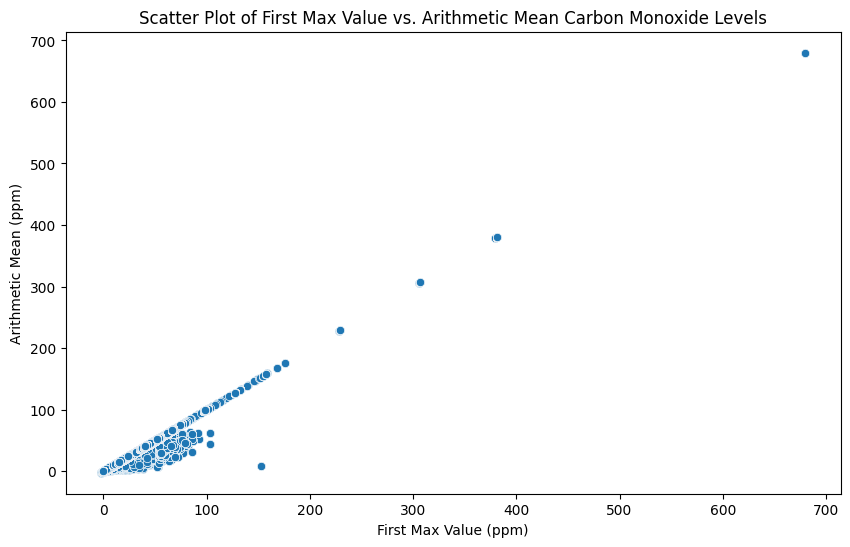

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.toPandas(), x="first_max_value", y="arithmetic_mean")
plt.title("Scatter Plot of First Max Value vs. Arithmetic Mean Carbon Monoxide Levels")
plt.xlabel("First Max Value (ppm)")
plt.ylabel("Arithmetic Mean (ppm)")
plt.show()


​The scatter plot illustrates the relationship between the first maximum value and the arithmetic mean of carbon monoxide levels. The plot shows a positive correlation, meaning that as the first maximum value increases, the arithmetic mean of carbon monoxide levels also tends to increase. However, the correlation is not perfectly linear, and there is some variability in the data.

## 9. Count of Observations by Event Type

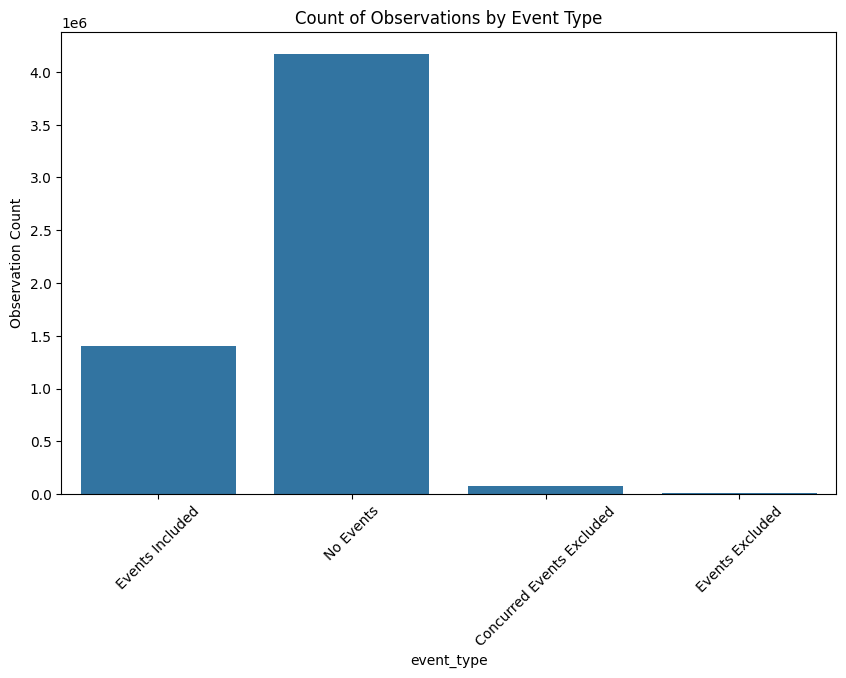

In [50]:
event_type_count = df.groupBy("event_type").agg({"observation_count": "sum"}).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=event_type_count, x="event_type", y="sum(observation_count)")
plt.title("Count of Observations by Event Type")
plt.ylabel("Observation Count")
plt.xticks(rotation=45)
plt.show()


​The bar chart shows the distribution of observations across different event types. The majority of observations fall under the "No Events" category, followed by "Events Included." The categories "Concurred Events Excluded" and "Event Excluded" have significantly fewer observations.

## 10. AQI Levels Over Time

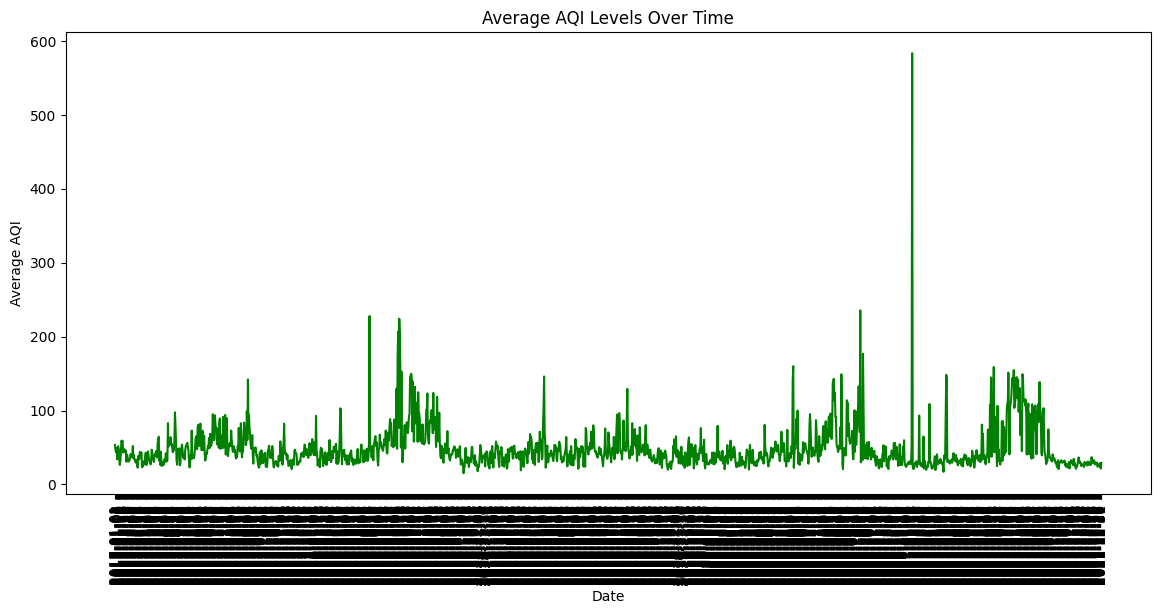

In [51]:
aqi_over_time = df.groupBy("date_local").agg({"aqi": "avg"}).orderBy("date_local").toPandas()
plt.figure(figsize=(14, 6))
plt.plot(aqi_over_time['date_local'], aqi_over_time['avg(aqi)'], color='green')
plt.title("Average AQI Levels Over Time")
plt.xlabel("Date")
plt.ylabel("Average AQI")
plt.xticks(rotation=90)
plt.show()


​The line chart shows the average AQI levels over time. The AQI levels fluctuate over time, with some periods of higher levels and some periods of lower levels. The chart also shows some seasonal patterns, with higher AQI levels in the summer months.

# Model Building

In [52]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

target_column = "aqi_category_index"

unwanted_columns = ["aqi", "aqi_category"]

string_columns = [c for c, t in df.dtypes if t == "string"]

string_columns = [c for c in string_columns if c != target_column]

stages = []

for col in string_columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_indexed")
    stages.append(indexer)

feature_columns = [col for col in df.columns if (col!= target_column and col!= unwanted_columns)]
feature_columns = [c + "_indexed" if c in string_columns else c for c in feature_columns]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
stages.append(assembler)

pipeline = Pipeline(stages=stages)

df_transformed = pipeline.fit(df).transform(df).select("features", F.col(target_column).alias("label"))

train_df, test_df = df_transformed.randomSplit([0.8, 0.2], seed=42)

X_train = train_df.select("features")
y_train = train_df.select("label")

X_test = test_df.select("features")
y_test = test_df.select("label")

train_df.printSchema()
test_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [53]:
X_train.show(5)

+--------------------+
|            features|
+--------------------+
|(33,[0,1,2,3,4,5,...|
|(33,[0,1,2,3,4,5,...|
|[8.0,1.0,8.0,8110...|
|[8.0,1.0,8.0,8110...|
|[8.0,1.0,8.0,8110...|
+--------------------+
only showing top 5 rows



In [54]:
y_train.show(5)

+-----+
|label|
+-----+
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
+-----+
only showing top 5 rows



In [55]:
x_train_rows = X_train.count()
y_train_rows = y_train.count()
x_test_rows = X_test.count()
y_test_rows = y_test.count()

x_train_cols = len(X_train.columns)
x_test_cols = len(X_test.columns)

print(f"X_train shape: ({x_train_rows}, {x_train_cols})")
print(f"y_train shape: ({y_train_rows}, 1)")
print(f"X_test shape: ({x_test_rows}, {x_test_cols})")
print(f"y_test shape: ({y_test_rows}, 1)")

X_train shape: (480052, 1)
y_train shape: (480052, 1)
X_test shape: (119572, 1)
y_test shape: (119572, 1)


### 1. Logistic Regression

Logistic Regression Metrics:
Train Accuracy: 0.9841829635122862
Test Accuracy: 0.9847539557755997
F1 Score: 0.984733040900173
Precision: 0.9847820119312329
Recall: 0.9847539557755995

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  387|
|  1.0|       1.0|19301|
|  0.0|       1.0|  190|
|  1.0|       0.0|  153|
|  2.0|       2.0|19615|
|  4.0|       4.0|19925|
|  3.0|       4.0|  173|
|  1.0|       2.0|  115|
|  5.0|       5.0|19949|
|  0.0|       0.0|19337|
|  1.0|       3.0|  403|
|  0.0|       2.0|  396|
|  3.0|       3.0|19622|
|  0.0|       3.0|    6|
+-----+----------+-----+



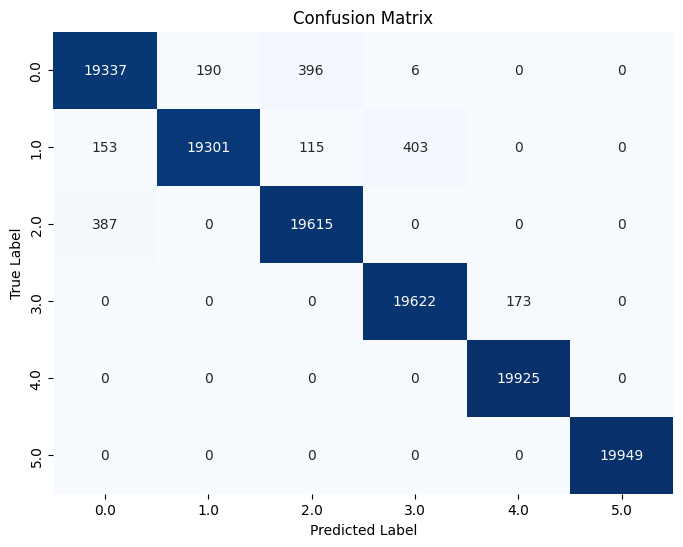

In [56]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(labelCol="label", featuresCol="features")

lr_model = lr.fit(train_df)

lr_predictions = lr_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
train_predictions = lr_model.transform(train_df)
train_accuracy = evaluator.evaluate(train_predictions, {evaluator.metricName: "accuracy"})
test_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})

print("Logistic Regression Metrics:")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

lr_predictions.groupBy("label", "prediction").count().show()

confusion_matrix_df = lr_predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix = confusion_matrix_df.pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 2. Decision Tree Classifier

Decision Tree Metrics:
Train Accuracy: 1.0
Test Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0



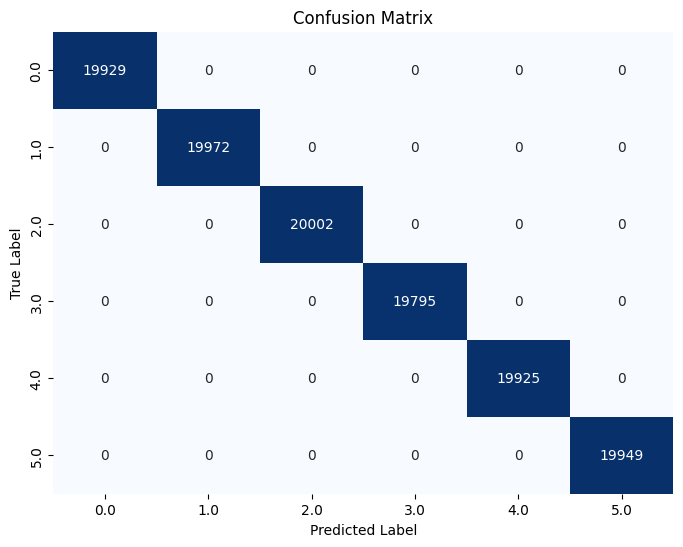

In [57]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=1826)

dt_model = dt.fit(train_df)

train_predictions = dt_model.transform(train_df)
dt_predictions = dt_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

train_accuracy = evaluator.evaluate(train_predictions, {evaluator.metricName: "accuracy"})
test_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})

print("Decision Tree Metrics:")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

confusion_matrix_df = dt_predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix = confusion_matrix_df.pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 3. Random Forest Classifier

Random Forest Metrics:
Train Accuracy: 1.0
Test Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0



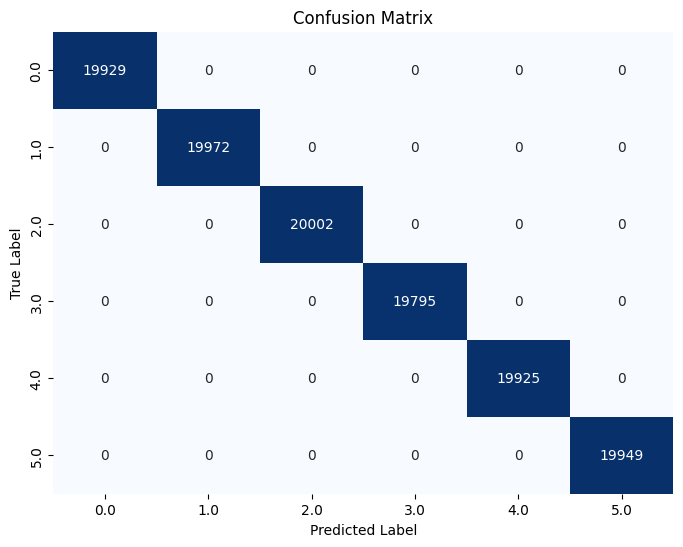

In [58]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, maxBins=1826)

rf_model = rf.fit(train_df)

train_predictions = rf_model.transform(train_df)
rf_predictions = rf_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

train_accuracy = evaluator.evaluate(train_predictions, {evaluator.metricName: "accuracy"})
test_accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})

print("Random Forest Metrics:")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

confusion_matrix_df = rf_predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix = confusion_matrix_df.pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 4. Naive Bayes

In [59]:
from pyspark.sql.functions import udf, col, array_contains
from pyspark.sql.types import BooleanType

# Define a UDF to check for negative values in an array
check_negative_udf = udf(lambda arr: any(x < 0 for x in arr), BooleanType())

# Apply the UDF within the filter
negative_values_count = train_df.filter(check_negative_udf(col("features"))).count()
print(f"Number of rows with negative values in features: {negative_values_count}")

Number of rows with negative values in features: 480052


Naive Bayes in PySpark requires the feature vectors to be non-negative because probabilities cannot be negative. Since there are negative values, we can apply a transformation, like scaling to ensure all features are non-negative.

In [60]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures", min=0.0, max=1.0)
scaler_model = scaler.fit(train_df)

train_df_scaled = scaler_model.transform(train_df).select("label", "scaledFeatures")
test_df_scaled = scaler_model.transform(test_df).select("label", "scaledFeatures")

In [61]:
train_df_scaled.select("scaledFeatures").rdd.flatMap(lambda row: row[0].values).filter(lambda x: x < 0).take(10)
test_df_scaled.select("scaledFeatures").rdd.flatMap(lambda row: row[0].values).filter(lambda x: x < 0).take(10)

[]

As we can see, still we have some negative values. Let's eliminate them by doing a simple transformation.

In [62]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT, DenseVector

# UDF to replace negative values with absolute values
def abs_vector(vec):
    return DenseVector([abs(x) for x in vec])

abs_udf = udf(abs_vector, VectorUDT())

train_df_scaled = train_df_scaled.withColumn("scaledFeatures", abs_udf("scaledFeatures"))
test_df_scaled = test_df_scaled.withColumn("scaledFeatures", abs_udf("scaledFeatures"))

In [63]:
train_df_scaled.select("scaledFeatures").rdd.flatMap(lambda row: row[0].values).filter(lambda x: x < 0).count()
test_df_scaled.select("scaledFeatures").rdd.flatMap(lambda row: row[0].values).filter(lambda x: x < 0).count()

0

Now, the negative values are none, which means we can proceed with the model training.

Naive Bayes Metrics:
Train Accuracy: 0.7850316215743295
Test Accuracy: 0.7854179908339745
F1 Score: 0.7867450250216793
Precision: 0.8017422592633301
Recall: 0.7854179908339746



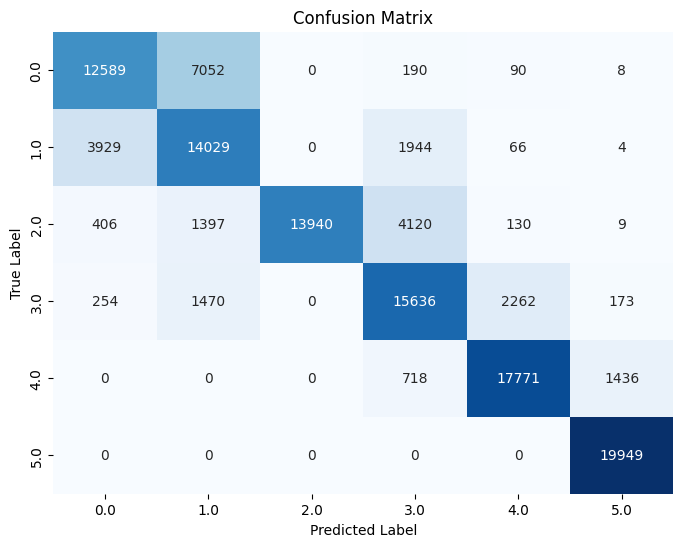

In [64]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol="label", featuresCol="scaledFeatures", smoothing=1.0, modelType="multinomial")
nb_model = nb.fit(train_df_scaled)

train_predictions = nb_model.transform(train_df_scaled)
nb_predictions = nb_model.transform(test_df_scaled)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

train_accuracy = evaluator.evaluate(train_predictions, {evaluator.metricName: "accuracy"})
test_accuracy = evaluator.evaluate(nb_predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(nb_predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedRecall"})

print("Naive Bayes Metrics:")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

confusion_matrix_df = nb_predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix = confusion_matrix_df.pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Fine Tuning Naive Bayes

#### 1. First Shot

In [65]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import MinMaxScaler

# # Scale features
# scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
# scaler_model = scaler.fit(train_df)
# train_df_scaled = scaler_model.transform(train_df).select("label", "scaledFeatures")
# test_df_scaled = scaler_model.transform(test_df).select("label", "scaledFeatures")

# Initialize Naive Bayes model
nb = NaiveBayes(labelCol="label", featuresCol="scaledFeatures", modelType="multinomial")

# Set up parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.001, 0.01, 0.1, 0.3, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0]) \
    .build()

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Use TrainValidationSplit for hyperparameter tuning
tvs = TrainValidationSplit(
    estimator=nb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8  # 80% of data for training and 20% for validation
)

# Fit the TrainValidationSplit model
tvs_model = tvs.fit(train_df_scaled)

# Get the best model and its parameters
best_model = tvs_model.bestModel
best_params = best_model._java_obj.parent().extractParamMap()

# Evaluate on training data
train_predictions = best_model.transform(train_df_scaled)
train_accuracy = evaluator.evaluate(train_predictions)

# Evaluate on test data
test_predictions = best_model.transform(test_df_scaled)
test_accuracy = evaluator.evaluate(test_predictions)

# Additional metrics
f1 = evaluator.evaluate(test_predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedRecall"})

Best Hyperparameter Values:
featuresCol: scaledFeatures
labelCol: label
modelType: multinomial
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
smoothing: 0.001

Model Metrics:
Training Accuracy: 0.7850857823735762
Test Accuracy: 0.7854514434817516
F1 Score: 0.7867850178354873
Precision: 0.8017812610891641
Recall: 0.7854514434817517


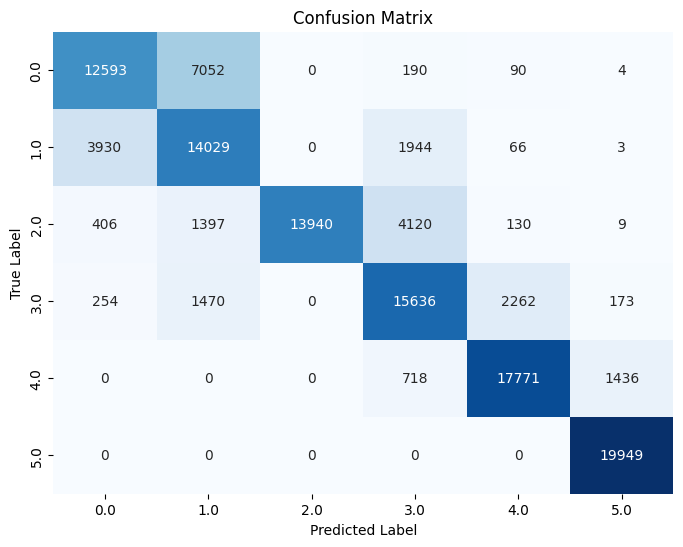

In [66]:
# Print best parameters and metrics
print("Best Hyperparameter Values:")
best_params = best_model.extractParamMap()  # Extract the best parameter map

for param, value in best_params.items():
    if isinstance(param, str):
        param_name = param  # Handle parameters as strings (rare edge case)
    else:
        param_name = param.name  # S
        print(f"{param_name}: {value}")

print("\nModel Metrics:")
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion matrix
confusion_matrix_df = test_predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix = confusion_matrix_df.pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Seems like low values of `smoothing` gives more accuracy. Now, let's test it by providing more lesser value of `smoothing` and see if our hypothesis is actually true.

#### 2. Second Shot

Best Hyperparameter Values:
featuresCol: scaledFeatures
labelCol: label
modelType: multinomial
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
smoothing: 1e-100
thresholds: [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]

Model Metrics:
Training Accuracy: 0.7907518352178514
Test Accuracy: 0.7912972936807948
F1 Score: 0.7920070388571503
Precision: 0.8061265445574524
Recall: 0.7912972936807949


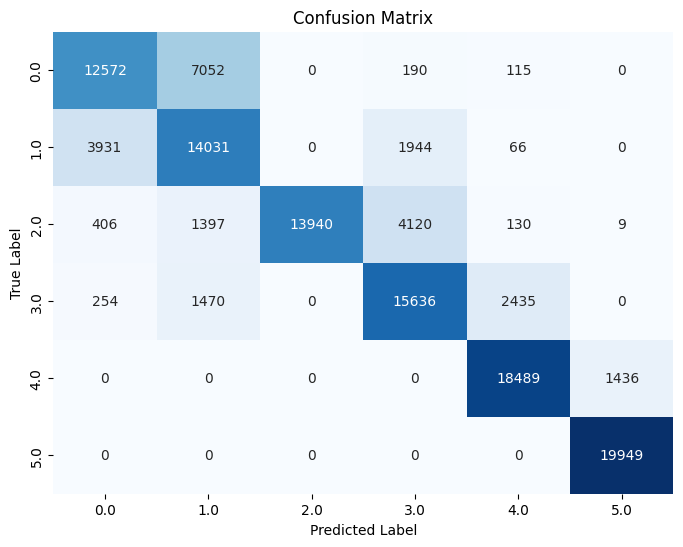

In [67]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import MinMaxScaler
import numpy as np

# # Scale features
# scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
# scaler_model = scaler.fit(train_df)
# train_df_scaled = scaler_model.transform(train_df).select("label", "scaledFeatures")
# test_df_scaled = scaler_model.transform(test_df).select("label", "scaledFeatures")

# Initialize Naive Bayes model
nb = NaiveBayes(labelCol="label", featuresCol="scaledFeatures")

# Set up parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [1e-100, 1e-15, 1e-10, 0.00001, 0.0001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0]) \
    .addGrid(nb.thresholds, [
        np.array([0.2, 0.2, 0.2, 0.2, 0.1, 0.1]),
        np.array([0.1, 0.3, 0.2, 0.2, 0.1, 0.1]),
        np.array([0.15, 0.15, 0.25, 0.25, 0.1, 0.1])
    ]) \
    .build()

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Use TrainValidationSplit for hyperparameter tuning
tvs = TrainValidationSplit(
    estimator=nb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8  # 80% of data for training and 20% for validation
)

# Fit the TrainValidationSplit model
tvs_model = tvs.fit(train_df_scaled)

# Get the best model and its parameters
best_model = tvs_model.bestModel
best_params = best_model._java_obj.parent().extractParamMap()

# Evaluate on training data
train_predictions = best_model.transform(train_df_scaled)
train_accuracy = evaluator.evaluate(train_predictions)

# Evaluate on test data
test_predictions = best_model.transform(test_df_scaled)
test_accuracy = evaluator.evaluate(test_predictions)

# Additional metrics
f1 = evaluator.evaluate(test_predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedRecall"})

# Print best parameters and metrics
print("Best Hyperparameter Values:")
best_params = best_model.extractParamMap()  # Extract the best parameter map

for param, value in best_params.items():
    if isinstance(param, str):
        param_name = param  # Handle parameters as strings (rare edge case)
    else:
        param_name = param.name  # S
        print(f"{param_name}: {value}")

print("\nModel Metrics:")
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion matrix
confusion_matrix_df = test_predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix = confusion_matrix_df.pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

So, from this we can conclude that lesser value of `smoothing ` parameter gives greater accuracy. Let's try with more lesser value to see how much accuracy the model can get max.

#### 3. Third Shot

Best Hyperparameter Values:
featuresCol: scaledFeatures
labelCol: label
modelType: multinomial
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
smoothing: 0.0
thresholds: [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]

Model Metrics:
Training Accuracy: 0.16680067992634132
Test Accuracy: 0.16666945438731476
F1 Score: 0.047620526827546694
Precision: 0.027778707025765195
Recall: 0.16666945438731476


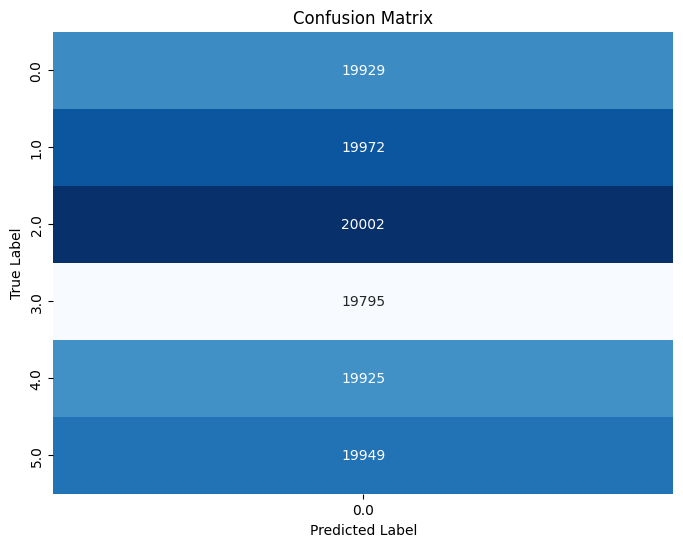

In [68]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import MinMaxScaler
import numpy as np

# # Scale features
# scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
# scaler_model = scaler.fit(train_df)
# train_df_scaled = scaler_model.transform(train_df).select("label", "scaledFeatures")
# test_df_scaled = scaler_model.transform(test_df).select("label", "scaledFeatures")

# Initialize Naive Bayes model
nb = NaiveBayes(labelCol="label", featuresCol="scaledFeatures")

# Set up parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [1e-10000, 1e-1000, 10e100]) \
    .addGrid(nb.thresholds, [
        np.array([0.2, 0.2, 0.2, 0.2, 0.1, 0.1]),
        np.array([0.1, 0.3, 0.2, 0.2, 0.1, 0.1]),
        np.array([0.15, 0.15, 0.25, 0.25, 0.1, 0.1])
    ]) \
    .build()

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Use TrainValidationSplit for hyperparameter tuning
tvs = TrainValidationSplit(
    estimator=nb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8  # 80% of data for training and 20% for validation
)

# Fit the TrainValidationSplit model
tvs_model = tvs.fit(train_df_scaled)

# Get the best model and its parameters
best_model = tvs_model.bestModel
best_params = best_model._java_obj.parent().extractParamMap()

# Evaluate on training data
train_predictions = best_model.transform(train_df_scaled)
train_accuracy = evaluator.evaluate(train_predictions)

# Evaluate on test data
test_predictions = best_model.transform(test_df_scaled)
test_accuracy = evaluator.evaluate(test_predictions)

# Additional metrics
f1 = evaluator.evaluate(test_predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedRecall"})

# Print best parameters and metrics
print("Best Hyperparameter Values:")
best_params = best_model.extractParamMap()  # Extract the best parameter map

for param, value in best_params.items():
    if isinstance(param, str):
        param_name = param  # Handle parameters as strings (rare edge case)
    else:
        param_name = param.name  # S
        print(f"{param_name}: {value}")

print("\nModel Metrics:")
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion matrix
confusion_matrix_df = test_predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix = confusion_matrix_df.pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

After several attempts, it has become evident that the accuracy is not improving significantly despite our efforts. This phenomenon is not uncommon in machine learning. There are instances where certain datasets do not perform well with specific models due to various underlying reasons.

Reasons -

- The chosen model's assumptions or architecture might not align well with the data's patterns or structure. For example, linear models might fail to capture complex, non-linear relationships in the data, while complex models like deep neural networks may overfit if the dataset is small or lacks variability.

- Hyperparameter tuning might not always yield substantial improvements if the model inherently lacks compatibility with the dataset.